In [2]:
import logging
import time

import numpy as np
import matplotlib.pyplot as plt

# import tensorflow_datasets as tfds
import tensorflow as tf
# import tensorflow_text

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchinfo as ti
import torchsummary as ts

# 사전 변수를 오브젝트 변수로
from attrdict import AttrDict

In [86]:
config = {'head_num':8,
          'd_model':256, 
          'd_ff':1024, 
          'max_position_embeddings':16, 
          'hidden_dropout_prob':0.1,
          'encoder_layer':3, 
          'decoder_layer':3,
          'layer_norm_eps': 1e-5,
          'vocab_size':30000}

config = AttrDict(config)

In [87]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")

token = tokenizer(['hello my name is kim. nice to meet you', 'hi how are u today?'], 
        padding='max_length', 
        truncation=True,
        max_length=config.max_position_embeddings,
        return_tensors='pt')
token

{'input_ids': tensor([[ 101, 7592, 2026, 2171, 2003, 5035, 1012, 3835, 2000, 3113, 2017,  102,
            0,    0,    0,    0],
        [ 101, 7632, 2129, 2024, 1057, 2651, 1029,  102,    0,    0,    0,    0,
            0,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]])}

In [88]:
def positional_encoding(config):
    
    depth = config.d_model
    length = config.max_position_embeddings
    
    # 각 위치에 대한 인덱스 생성
    positions = np.arange(length)[:, np.newaxis]          # (seq, 1)
    depths = np.arange(depth)[np.newaxis, :] / depth  # (1, depth)

    # 각 깊이에 대한 각도 비율 계산
    angle_rates = 1 / (10000 ** depths)          # (1, depth)
    angle_rads = positions * angle_rates        # (pos, depth)

    # sin과 cos을 사용하여 위치 인코딩 생성
    sin = torch.from_numpy(np.sin(angle_rads)).to(torch.float32)
    cos = torch.from_numpy(np.cos(angle_rads)).to(torch.float32)

    # (pos, depth)
    pos_embedding = torch.zeros((config.max_position_embeddings, config.d_model))
    
    # sin은 짝수 인덱스, cos은 홀수 인덱스만을 쓰기 위함
    even_index = np.arange(config.max_position_embeddings) % 2 == 0
    odd_index = ~even_index
    
    pos_embedding[even_index] = sin[even_index]
    pos_embedding[odd_index] = cos[odd_index]

    return pos_embedding

In [89]:
#positional_encoding 함수는 길이가 2048, 깊이가 512인 위치 인코딩 행렬을 생성합니다.
class PositionalEmbedding(nn.Module):
    def __init__(self, config):
        super(PositionalEmbedding, self).__init__()
        self.config = config
        self.embedding = nn.Embedding(config.vocab_size, config.d_model, padding_idx=0)
        self.pos_encoding = positional_encoding(config)

    def compute_mask(self, *args, **kwargs):
        # 마스크 계산 (패딩된 부분을 모델이 무시하도록 함)
        return self.embedding.compute_mask(*args, **kwargs)

    def forward(self, x):
        seq = self.config.max_position_embeddings    # 입력 시퀀스의 길이
        token_embeddings = self.embedding(x)    # 단어 임베딩 적용
        token_embeddings *= np.sqrt(self.config.d_model, dtype=np.float32) # 임베딩 크기 조정
        # x = x + self.pos_encoding[tf.newaxis, :length, :]     # 위치 인코딩 추가
        positional_embeddings = self.pos_encoding
        embedding = token_embeddings + positional_embeddings
        
        return embedding

In [197]:
class MultiHeadAttn(nn.Module):
    def __init__(self, config):
        super().__init__()
        
        self.config = config
        
        self.d_model = config.d_model
        self.max_position_embeddings = config.max_position_embeddings
        self.head_num = config.head_num
        
        self.attention_head_size = int(config.d_model / config.head_num)
        self.all_head_size = config.head_num * self.attention_head_size

        self.query = nn.Linear(config.d_model, self.all_head_size, bias=True)
        self.key = nn.Linear(config.d_model, self.all_head_size, bias=True)
        self.value = nn.Linear(config.d_model, self.all_head_size, bias=True)

        self.dropout = nn.Dropout(p=config.hidden_dropout_prob)
        
    def to_multi_head(self, layer):
        '''
            input layer shape : batch * seq * dim
            output layer shape : batch * head_attn_num * seq * dim//head_attn_num
        '''
        return layer.view(layer.size()[:1][0], 
                          self.config.head_num, 
                          self.config.max_position_embeddings, 
                          self.attention_head_size)
        
    def forward(self, input_tensor, padding_mask = None, token_type_ids = None):
        
        query_layer = self.query(input_tensor)
        key_layer = self.key(input_tensor)
        value_layer = self.value(input_tensor)
        
        # print('query layer shape : {}'.format(query_layer.shape))
        # print('key layer shape : {}'.format(key_layer.shape))
        # print('value layer shape : {}'.format(value_layer.shape))
        
        multi_query_layer = self.to_multi_head(query_layer)
        multi_key_layer = self.to_multi_head(key_layer)
        multi_value_layer = self.to_multi_head(value_layer)
  
        # print('multi query layer shape : {}'.format(multi_query_layer.shape))
        # print('multi key layer shape : {}'.format(multi_key_layer.shape))
        # print('multi value layer shape : {}'.format(multi_value_layer.shape))
        
        matmul = multi_query_layer @ multi_key_layer.transpose(2, 3)
        
        matmul /= np.sqrt(self.config.d_model // self.config.head_num)
        
        # mask(opt) pass, padding 큰 음수 주기
        if padding_mask is not None:
            # bs * 1 * seq * seq
            size_up = torch.ones(input_tensor.size(0), 1, self.max_position_embeddings, self.max_position_embeddings)
            
            mask = padding_mask.unsqueeze(1).unsqueeze(-1) * padding_mask.unsqueeze(1).unsqueeze(2) * size_up
            matmuled = matmul.masked_fill(mask == 0, -1e9)
        
        attn_probs = nn.Softmax(dim=-1)(matmuled)
        
        attn_score = self.dropout(attn_probs)
        # print('attn score shape : {}'.format(attn_score.shape))
        
        attn_score = attn_score @ multi_value_layer
        attn_score = attn_score.view(input_tensor.size()[:1][0], self.config.max_position_embeddings, self.config.d_model)
        
        return attn_score, attn_probs, matmul, mask

In [198]:
# tensor.size(1)
# batch, seq, embedding
pos_model = PositionalEmbedding(config)

d_model = config.d_model
batch = token['input_ids'].size(0)
seq = token['input_ids'].size(1)

input_ids = pos_model(token['input_ids'])
scaled_dot_pro = MultiHeadAttn(config)
scaled_dot_pro

MultiHeadAttn(
  (query): Linear(in_features=256, out_features=256, bias=True)
  (key): Linear(in_features=256, out_features=256, bias=True)
  (value): Linear(in_features=256, out_features=256, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [199]:
matmul, attn_probs, matmul, mask = scaled_dot_pro(input_ids, padding_mask=token['attention_mask'])
matmul.shape, attn_probs.shape

(torch.Size([2, 8, 16, 16]), torch.Size([2, 8, 16, 16]))

In [133]:
# temp_matmul = matmul.masked_fill(maks2 == 0, -1e9)
# temp_matmul.shape

In [134]:
# temp_matmul[0][0]

In [166]:
def visualization_attn_score(token, attn_probs, suptitle):
    
    fig, axs = plt.subplots(4, 2, figsize=(10, 15), layout='constrained')
    
    t = 0
    token_0 = [tokenizer.decode(token_) for token_ in token]
    token_0_len = len(token_0)
    
    for x in range(4):
        for y in range(2):

            ax = axs[x][y]

            ax.matshow(attn_probs[0][t].detach().numpy())
            ax.set_xticks(range(token_0_len), token_0, rotation=90)
            ax.xaxis.tick_bottom()
            ax.set_yticks(range(token_0_len), token_0)

            t += 1

            ax.set_title('Head number : {}'.format(t))
            
    plt.suptitle(suptitle)
    plt.show()

In [167]:
temp_matmul[0].shape

torch.Size([4, 16, 16])

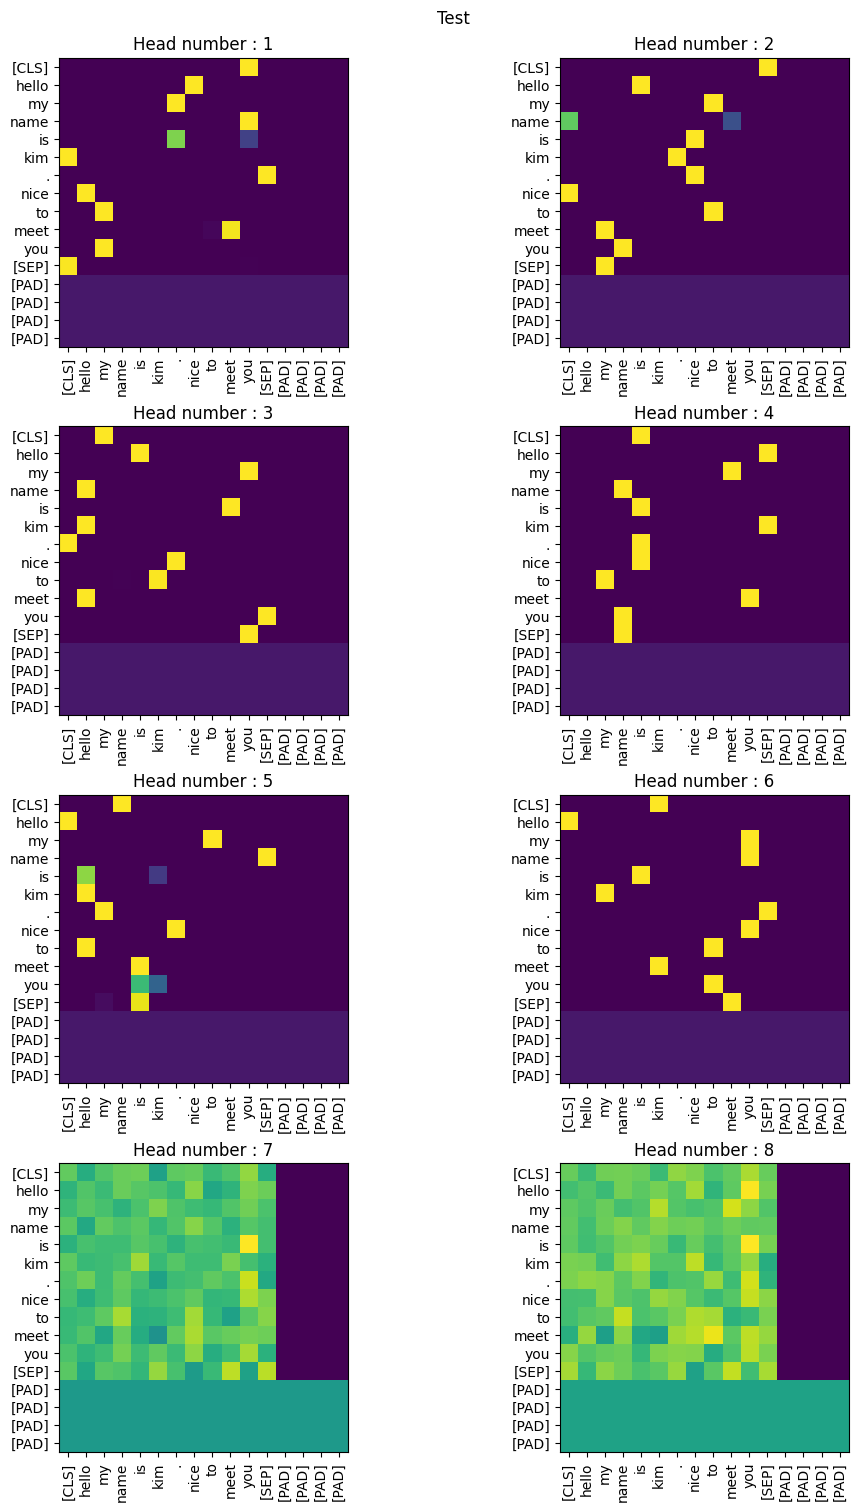

In [207]:
visualization_attn_score(token['input_ids'][0], attn_probs, 'Test')

In [169]:
# visualization_attn_score(token['input_ids'][0], matmul, 'Test')

In [104]:
mask

tensor([[[[1., 1., 1.,  ..., 0., 0., 0.],
          [1., 1., 1.,  ..., 0., 0., 0.],
          [1., 1., 1.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[1., 1., 1.,  ..., 0., 0., 0.],
          [1., 1., 1.,  ..., 0., 0., 0.],
          [1., 1., 1.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[1., 1., 1.,  ..., 0., 0., 0.],
          [1., 1., 1.,  ..., 0., 0., 0.],
          [1., 1., 1.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         ...,

         [[1., 1., 1.,  ..., 0., 0., 0.],
          [1., 1., 1.,  ..., 0., 0., 0.],
          [1., 1., 1.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 

In [85]:
attn_probs[0][0]

tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00, 8.3350e-14, 0.0000e+00, 5.9507e-31,
         4.1275e-05, 9.9996e-01, 1.4461e-42, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 9.9614e-01, 0.0000e+00, 1.3065e-05, 0.0000e+00,
         2.7607e-10, 3.8447e-03, 0.0000e+00, 3.5646e-06, 2.9162e-16, 8.3806e-33,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.3435e-38, 0.0000e+00, 0.0000e+00, 4.8802e-03, 0.0000e+00, 0.0000e+00,
         2.5787e-28, 0.0000e+00, 9.9512e-01, 0.0000e+00, 4.0638e-42, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.1210e-44, 1.8566e-03, 2.8026e-45, 2.0201e-10, 0.0000e+00, 1.8631e-09,
         1.4013e-45, 3.3833e-15, 0.0000e+00, 0.0000e+00, 0.0000e+00, 9.9814e-01,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 2.7282e-31, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000

In [10]:
size_up = torch.ones(token['input_ids'].size(0),
         1, 
         config.max_position_embeddings, 
         config.max_position_embeddings)

In [11]:
padding_mask = token['attention_mask']
mask = padding_mask.unsqueeze(1).unsqueeze(2) * size_up
mask.shape

torch.Size([2, 1, 16, 16])

In [37]:
maks2 = padding_mask.unsqueeze(1).unsqueeze(-1) * padding_mask.unsqueeze(1).unsqueeze(2) * size_up

In [56]:
padding_mask.unsqueeze(1)

tensor([[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0]],

        [[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]]])

In [55]:
padding_mask.unsqueeze(1).unsqueeze(-1) * padding_mask.unsqueeze(1).unsqueeze(2)

tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]],


        [[[1, 1, 1, 1, 1, 1, 1, 1, 0

In [ ]:
matmul.masked_fill(mask == 0, -1e9)

In [190]:
causal_mask = torch.tril(torch.ones(config.max_position_embeddings, config.max_position_embeddings))  # Upper triangular mask
causal_mask

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1

In [192]:
causal_mask = torch.tril(torch.ones(config.max_position_embeddings, config.max_position_embeddings)) # Upper triangular mask
size_up = torch.ones(token['input_ids'].size(0), 1, config.max_position_embeddings, config.max_position_embeddings)
mask = padding_mask.unsqueeze(1).unsqueeze(2) * padding_mask.unsqueeze(1).unsqueeze(-1) * size_up
causal_mask = causal_mask * mask
# causal_mask

In [193]:
(causal_mask * mask)

tensor([[[[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0

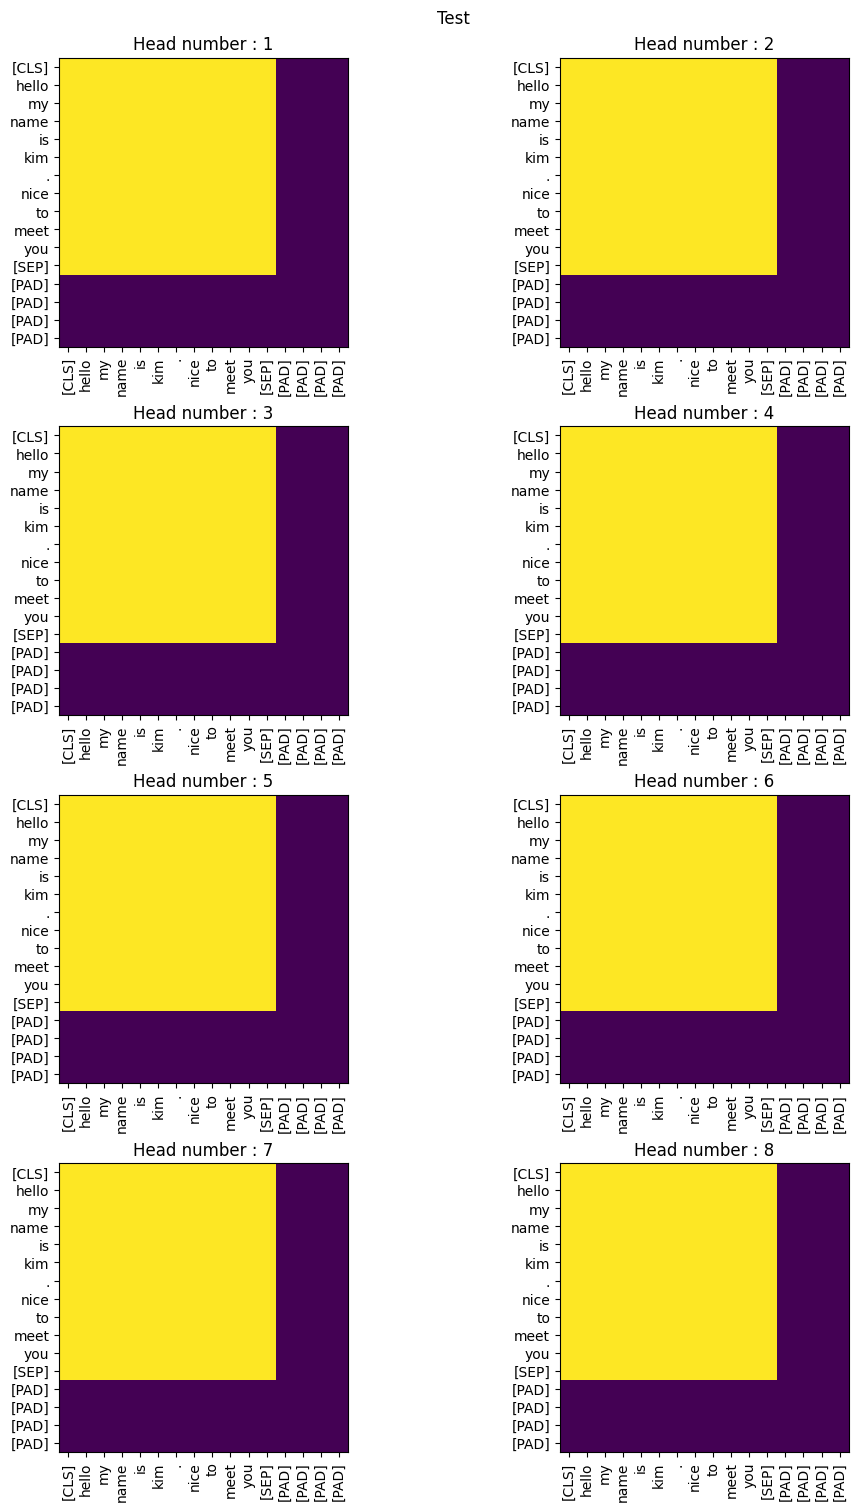

In [205]:
visualization_attn_score(token['input_ids'][0], matmul.masked_fill(mask == 0, -1e9), 'Test')

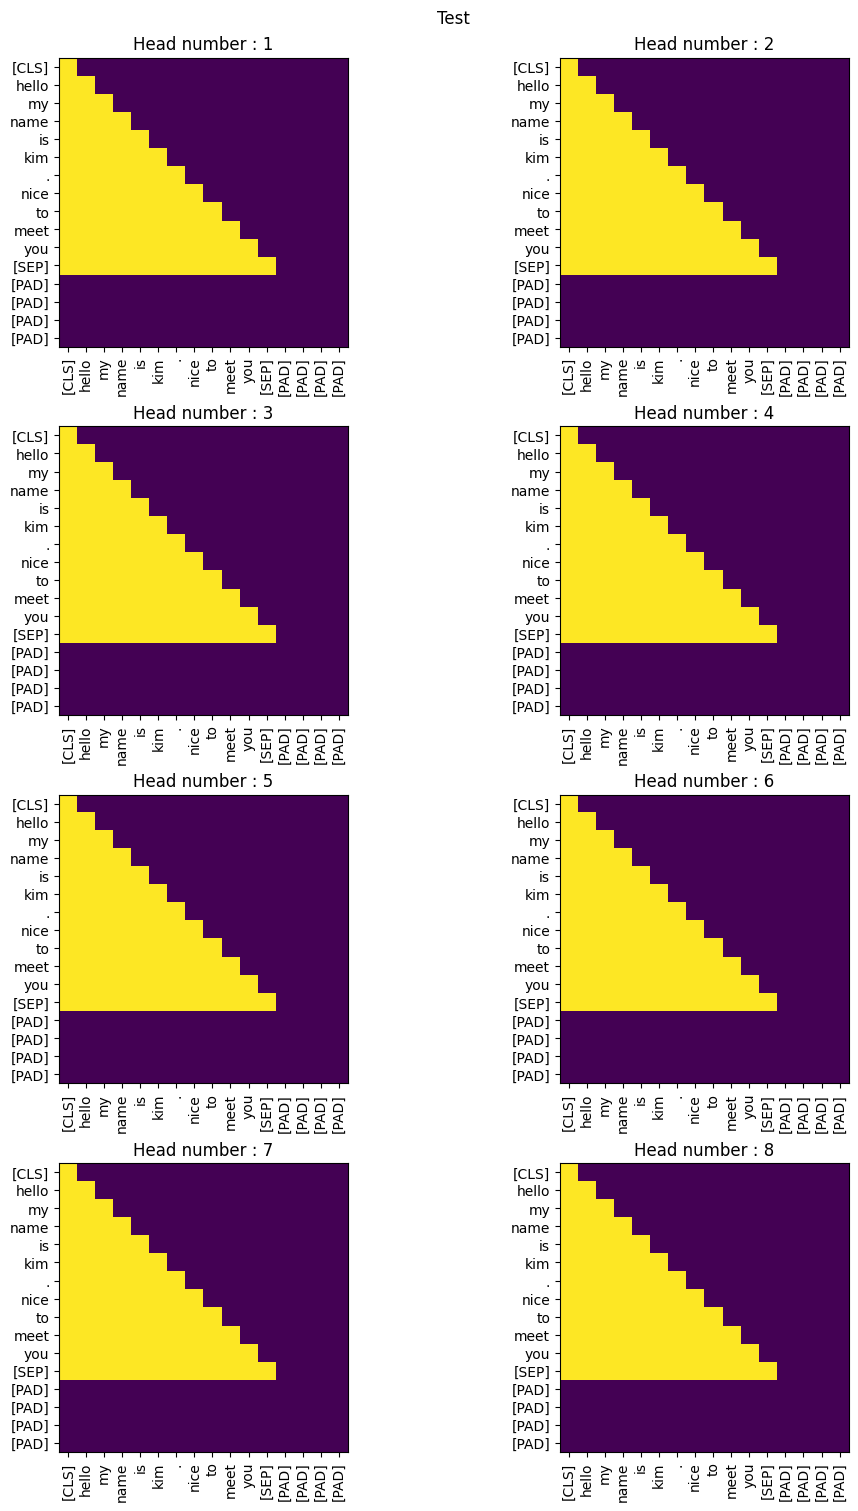

In [206]:
causal_masked = causal_mask * mask
visualization_attn_score(token['input_ids'][0], matmul.masked_fill(causal_masked == 0, -1e9), 'Test')

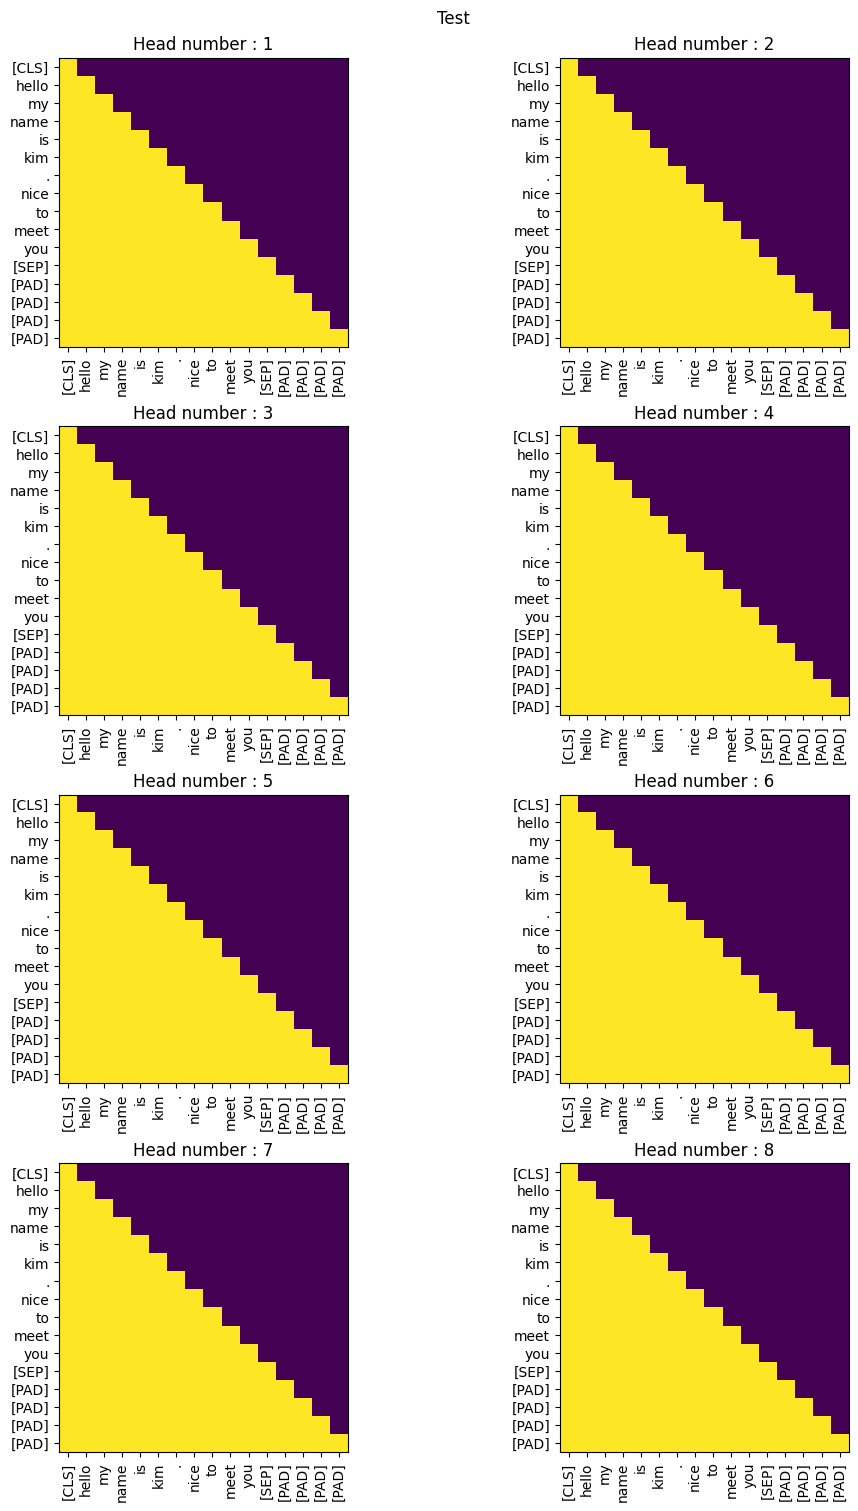

In [203]:
visualization_attn_score(token['input_ids'][0], matmul.masked_fill(causal_mask == 0, -1e9), 'Test')